In [1]:
import os
import sys
from os import path

# add current directory to path
sys.path.append(os.getcwd())
# if we are in notebooks/, cd .. to project root
if path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from soil_diskin.models import LognormalDisKin
from scipy import stats
from scipy import integrate
from tqdm import tqdm

import viz 
# use the style file
plt.style.use('notebooks/style.mpl')

colors = viz.color_palette()

color_name_order = np.array([k for k, _ in colors.items()])
np.random.shuffle(color_name_order)
color_order = [colors[n] for n in color_name_order]

LAMBDA_14C = 1/8267.0

In [3]:
class LogNormalSimulation:
    def __init__(self, mu, sigma):
        """Initialize the log-normal simulation.
        
        Args:
            mu (float): Mean of the underlying normal distribution.
            sigma (float): Standard deviation of the underlying normal distribution.
        """
        self.mu = mu
        self.sigma = sigma

        self.g_ts = None
        self.ts = None
        self.G_t = None

    @classmethod
    def lognormal_integrand(cls, k, mu, sigma):
        """Integrand for the log-normal survival function."""
        p_k = stats.lognorm.pdf(k, s=sigma, scale=np.exp(mu))
        return np.exp(-k) * p_k

    def survival_fn(self, ages):
        """Define a log-normal survival function.

        survival function is the integral of exp(-k) p(k) dk from k=0 to current age
        where p(k) is the log-normal probability density function.
        
        Parameters:
            ages (array-like): Array of ages.
        """
        # do finer age-stepping than requested for better integral approximation
        n = len(ages)*10
        fine_ages = np.linspace(0, np.max(ages), num=n)

        # calculate the log-normal probability density function
        p_k = stats.lognorm.pdf(fine_ages, s=self.sigma, scale=np.exp(self.mu))

        # integrate exp(-k) * p(k) dk from k=0
        def integrand(k, mu, sigma):
            return np.exp(-k) * stats.lognorm.pdf(k, s=sigma, scale=np.exp(mu))
        integrate.quad(integrand, 0, ages[-1], args=(self.mu, self.sigma))
    
    def run(self, inputs):
        """Run the simulation over the specified time steps.

        Note: assumes inputs occur at each time step, so that 
        the timesteps = np.arange(len(inputs)).

        Stores state in this object.

        Parameters:
            inputs (array-like): Input values at each time step.
        """
        n_time_steps = len(inputs)
        ts = np.arange(n_time_steps)

        # g_ts contains the decayed inputs over time
        # each row is an input at time t=i
        # each column is the amount remaining at time t+age        
        g_ts = np.zeros((n_time_steps, n_time_steps))

        g_ts = np.zeros((len(inputs), len(ts)+len(inputs) + 10))
        for i in range(n_time_steps):
            decay_i = inputs[i]*self.survival_fn(np.arange(n_time_steps))
            g_ts[i, i:i+len(decay_i)] = decay_i
            
        self.g_ts = g_ts.copy()
        self.ts = ts
        self.G_t = np.sum(self.g_ts, axis=0)

        return g_ts, ts

In [4]:
def calc_survival(mu, sigma, ln_ks, ts):
    k_amts = stats.norm.pdf(ln_ks, loc=mu, scale=sigma)
    ks = np.exp(ln_ks)
    k_amts_normed = k_amts / np.sum(k_amts)

    M = np.zeros((len(ks), len(ts)))
    for j, t in enumerate(ts):
        exponent = -ks * t
        exponential_prefactor = np.exp(exponent)
        frac_remaining = exponential_prefactor * k_amts_normed
        M[:, j] = frac_remaining

    # survival function is the sum over all k of M
    return M

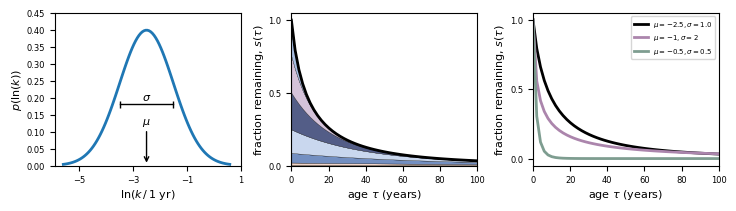

In [5]:
mosaic = 'ABC'
fig, axs = plt.subplot_mosaic(mosaic, layout='constrained', figsize=(7.25, 2))

# if Y ~ normal(mu, sigma) then X = exp(Y) ~ lognormal(mu, sigma)
mu = -2.5
sigma = 1

# plot the pdf with a logarithmic x-axis
plt.sca(axs['A'])

# plot the pdf of a log-normal distribution with parameters mu, sigma
qs = [0.001, 0.5, 0.999]
qvals = stats.norm.ppf(qs, loc=mu, scale=sigma)
ln_k_s = np.linspace(qvals[0], qvals[-1], 100)
p_ln_ks = stats.norm.pdf(ln_k_s, loc=mu, scale=sigma)

# plot the pdf, filling with white at alpha=0.5
plt.plot(ln_k_s, p_ln_ks)
plt.fill_between(ln_k_s, np.zeros_like(p_ln_ks), p_ln_ks, color='white', alpha=0.5)

# pick 10 samples to highlight as colored bars
ln_k_s = np.linspace(mu - 3*sigma, mu + 3*sigma, 10)
ks = np.exp(ln_k_s)
k_amts = stats.norm.pdf(ln_k_s, loc=mu, scale=sigma)

# plt.bar(ln_k_s, k_amts, width=0.5, color=color_order[:10],
#         edgecolor='k', lw=0.5, label='sampled bins',
#         zorder=-10)

plt.annotate(r'$\mu$', xy=(mu, 0.0), xytext=(mu, 0.12),
             ha='center', fontsize=8,
             bbox=dict(boxstyle='round,pad=0.01', edgecolor='none', facecolor='None'),
             arrowprops=dict(arrowstyle='->', lw=1))
plt.text(mu, 0.2, r'$\sigma$', ha='center', va='center', fontsize=8)
plt.plot([mu-sigma, mu + sigma], [0.18, 0.18], color='k', lw=1)
plt.vlines([mu - sigma, mu + sigma], ymin=0.17, ymax=0.19, color='k', lw=1)

plt.xlabel(r'$\ln(k \, / \, 1 \text{ yr})$', fontsize=8)
plt.ylabel(r'$p(\ln(k))$', fontsize=8)
plt.xticks(np.arange(-5, 1.1, 2))
plt.ylim(0, 0.45)
# plt.title('log-normal rate constants')

plt.sca(axs['B'])
# sample 100 bins from normal(mu, sigma)
k_amts_normed = k_amts / np.sum(k_amts)

ts = np.linspace(0, 200, 100)
M = calc_survival(mu, sigma, ln_k_s, ts)

plt.stackplot(ts, M, colors=color_order[:len(ln_k_s)],
              edgecolor='k', lw=0.2)
# # annotate single slice as e^-kt*p(k)*J_0
# plt.annotate(r'$e^{-k \tau} \, p(k)$',
#              xy=(2, 0.3), xytext=(12, 0.5),
#              ha='left', va='bottom',
#              bbox=dict(boxstyle='round,pad=0.01', edgecolor='none', facecolor='None'),
#              arrowprops=dict(arrowstyle='->', lw=1))
# plt.annotate(r'$s(\tau) = \int_0^\infty e^{-k \tau} \, p(k) \, dk$',
#              xy=(20, 0.25), xytext=(30, 0.35),
#              ha='left', va='bottom',
#              bbox=dict(boxstyle='round,pad=0.01', edgecolor='none', facecolor='None'),
#              arrowprops=dict(arrowstyle='->', lw=1))

# survival function is the sum over all k of M
survival_function = np.sum(M, axis=0)
plt.plot(ts, survival_function, color='k', lw=2)
plt.xlim(0, 100)
# plt.title(r'survival function, $s(\tau)$')
plt.xlabel(r'age $\tau$ (years)', fontsize=8)
plt.ylabel(r'fraction remaining, $s(\tau)$', fontsize=8)
plt.yticks(np.arange(0, 1.1, 0.5))

plt.sca(axs['C'])

mus = [-2.5, -1, -0.5]
sigmas = [1.0, 2, 0.5]
my_colors = ['k', colors['purple'], colors['dark_green']]

for mu, sigma, color in zip(mus, sigmas, my_colors):
    M = calc_survival(mu, sigma, ln_k_s, ts)
    plt.plot(ts, np.sum(M, axis=0), label=f'$\mu={mu}, \sigma={sigma}$', color=color)
plt.xlim(0, 100)
plt.yticks(np.arange(0, 1.1, 0.5))
plt.ylabel(r'fraction remaining, $s(\tau)$', fontsize=8)
plt.xlabel(r'age $\tau$ (years)', fontsize=8)
plt.legend(loc='upper right')

#plt.savefig('../figures/presentation_lognormal_example.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
mus = np.linspace(-2.5, 0, 100)
sigmas = np.linspace(0.1, 2, 100)
MU, SIGMA = np.meshgrid(mus, sigmas, indexing='xy')
T_matrix = np.zeros((len(mus), len(sigmas)))
R_14C_matrix = np.zeros((len(mus), len(sigmas)))

for i, j in tqdm(np.ndindex(MU.shape), total=MU.size):
    mu = MU[i, j]
    sigma = SIGMA[i, j]

    my_model = LognormalDisKin(mu=mu, sigma=sigma)

    # calculate mean age
    T_matrix[i, j] = my_model.T

100%|██████████| 10000/10000 [00:01<00:00, 7995.38it/s]


/var/folders/bm/mmlmzvwn36sbfm6ks9_nddlw0000gn/T/ipykernel_51298/1115693738.py:13: UserWarning: linewidths is ignored by contourf
  contour = plt.contourf(SIGMA, MU, T_matrix, levels=[35, 45],
/var/folders/bm/mmlmzvwn36sbfm6ks9_nddlw0000gn/T/ipykernel_51298/1115693738.py:13: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  contour = plt.contourf(SIGMA, MU, T_matrix, levels=[35, 45],


mu=-2.50, sigma=1.52, T=38.69
mu=-2.50, sigma=1.54, T=39.84
mu=-2.47, sigma=1.54, T=38.85
mu=-2.50, sigma=1.56, T=41.04
mu=-2.47, sigma=1.56, T=40.02
mu=-2.45, sigma=1.56, T=39.02
mu=-2.42, sigma=1.56, T=38.05
mu=-2.47, sigma=1.58, T=41.24
mu=-2.45, sigma=1.58, T=40.21
mu=-2.42, sigma=1.58, T=39.21
mu=-2.40, sigma=1.58, T=38.23
mu=-2.45, sigma=1.60, T=41.46
mu=-2.42, sigma=1.60, T=40.42
mu=-2.40, sigma=1.60, T=39.41
mu=-2.37, sigma=1.60, T=38.43
mu=-2.42, sigma=1.62, T=41.69
mu=-2.40, sigma=1.62, T=40.65
mu=-2.37, sigma=1.62, T=39.64
mu=-2.35, sigma=1.62, T=38.65
mu=-2.40, sigma=1.64, T=41.94
mu=-2.37, sigma=1.64, T=40.89
mu=-2.35, sigma=1.64, T=39.87
mu=-2.32, sigma=1.64, T=38.88
mu=-2.35, sigma=1.65, T=41.15
mu=-2.32, sigma=1.65, T=40.12
mu=-2.30, sigma=1.65, T=39.12
mu=-2.27, sigma=1.65, T=38.15
mu=-2.32, sigma=1.67, T=41.43
mu=-2.30, sigma=1.67, T=40.39
mu=-2.27, sigma=1.67, T=39.39
mu=-2.25, sigma=1.67, T=38.40
mu=-2.30, sigma=1.69, T=41.72
mu=-2.27, sigma=1.69, T=40.68
mu=-2.25, 

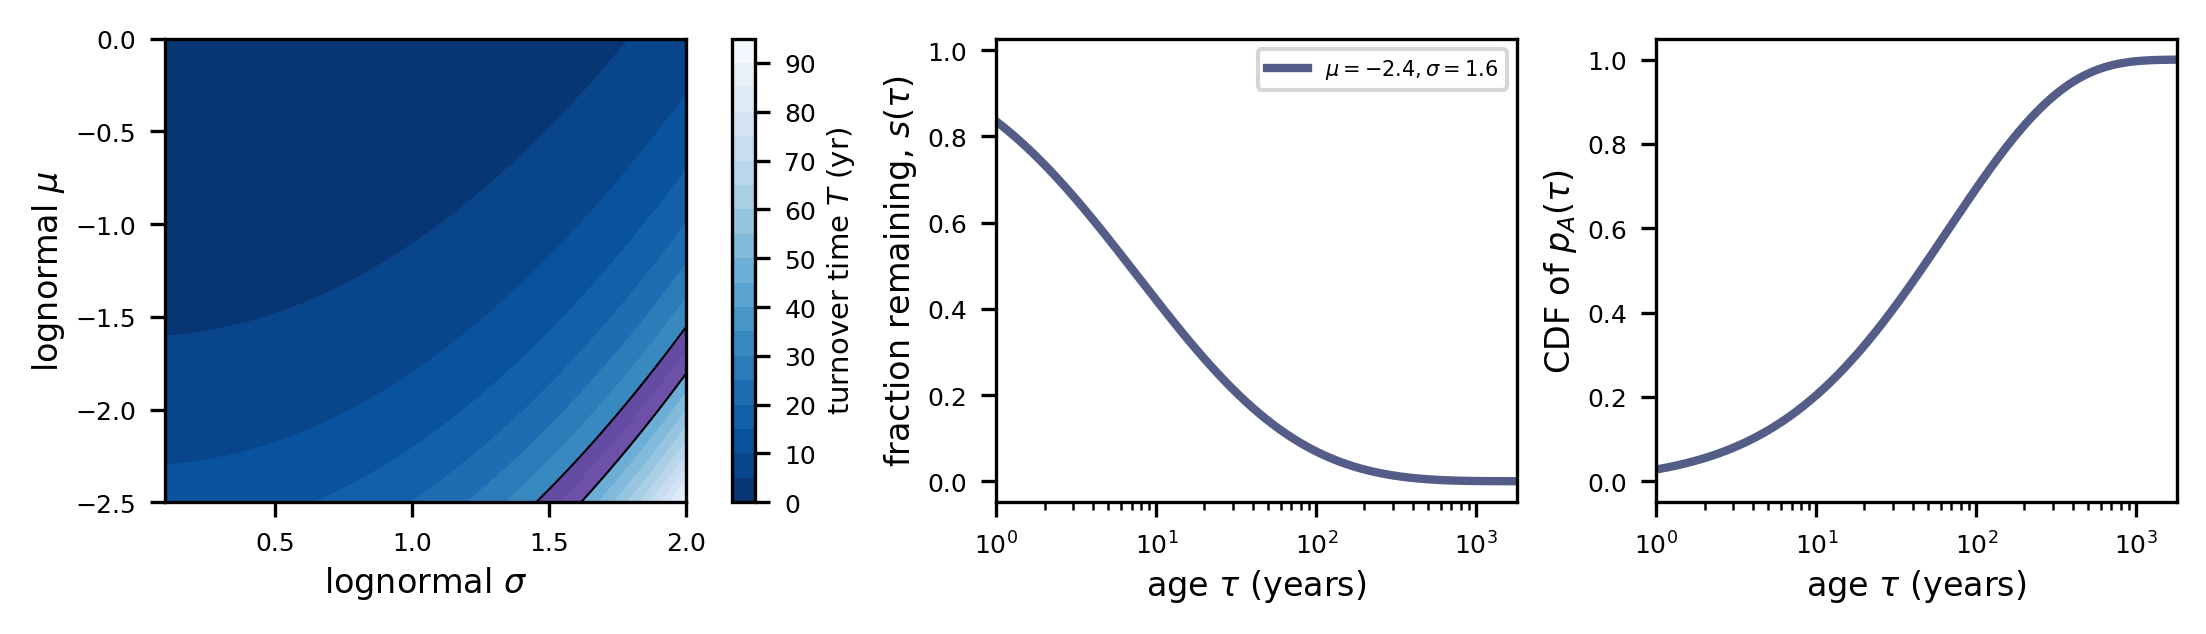

In [7]:
# filled contour plot of T as a function of mu and sigma
# with mu on the X axis and sigma on the Y axis
mosaic = 'ABC'
fig, axs = plt.subplot_mosaic(mosaic, figsize=(7.24, 2), dpi=300, layout='constrained')

plt.sca(axs['A'])
cs = plt.contourf(SIGMA, MU, T_matrix, levels=20, cmap='Blues_r')
cbar = plt.colorbar(cs, ax=axs['A'])
cbar.set_label(r'turnover time $T$ (yr)', fontsize=7)

# Highlight the section where 38 <= T <= 42 yr with a
# filled contour in colors['purple']
contour = plt.contourf(SIGMA, MU, T_matrix, levels=[35, 45],
                      colors='purple', linewidths=1, 
                      edgecolor='k', alpha=0.5)
plt.contour(SIGMA, MU, T_matrix, levels=[35, 45],
           colors='k', linewidths=0.5)

plt.xlabel(r'lognormal $\sigma$', fontsize=8)
plt.ylabel(r'lognormal $\mu$', fontsize=8)
plt.xticks(np.arange(0.5, 2.1, 0.5))
plt.yticks(np.arange(-2.5, 0.1, 0.5))

# Inferred s(tau) from the data
plt.sca(axs['B'])
plt.xscale('log')

# print pairs of mu and sigma that have T in [38, 42]
for i, j in np.ndindex(MU.shape):
    T_val = T_matrix[i, j]
    if 38 <= T_val <= 42:
        print(f"mu={MU[i,j]:.2f}, sigma={SIGMA[i,j]:.2f}, T={T_val:.2f}")

ts = np.logspace(-1, 4, 5000)
mu = -2.4
sigma = 1.6
my_model = LognormalDisKin(mu=mu, sigma=sigma)
print(f"Chosen mu={mu}, sigma={sigma}, T={my_model.T}")

M = calc_survival(mu, sigma, ln_k_s, ts)
s_tau = np.sum(M, axis=0)
plt.plot(ts, s_tau,
         label=f'$\mu={mu}, \sigma={sigma}$',
         color=colors['dark_blue'])
plt.xlabel(r'age $\tau$ (years)', fontsize=8)
plt.ylabel(r'fraction remaining, $s(\tau)$', fontsize=8)
plt.xlim(1, 1800)
plt.legend(loc=1)

# panel C -- plot the CDF of the steady-state age distribution
plt.sca(axs['C'])
plt.xscale('log')
# PDF pA = s(tau) / T
pA = s_tau / my_model.T
# CDF is the integral of pA
# Normalize pA so that it integrates to 1.0
pA_integral = integrate.trapezoid(pA, ts)
pA_normalized = pA / pA_integral
# CDF is the integral of the normalized pA
cdf_A = integrate.cumulative_trapezoid(pA_normalized, ts, initial=0)
plt.plot(ts, cdf_A, color=colors['dark_blue'])
plt.xlabel(r'age $\tau$ (years)', fontsize=8)
plt.ylabel(r'CDF of $p_A(\tau)$', fontsize=8)
plt.xlim(1, 1800)

plt.savefig('figures/lognormal_calibration_highlight.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
my_model = LognormalDisKin(mu=1.753, sigma=0)
print(f'{my_model.mu:.3f}, sigma: {my_model.sigma:.3f}, T: {my_model.T:.2f} yr')
np.exp((-my_model.mu + my_model.sigma**2)/2)

1.753, sigma: 0.000, T: 0.17 yr


np.float64(0.4162371953843658)

In [9]:

site_data = pd.read_csv('results/all_sites_14C_turnover.csv')
age_scan = pd.read_csv('results/03_calibrate_models/03b_lognormal_model_age_scan.csv', header=None)

In [10]:
site_data

,Latitude,Longitude,14C,NPP,Ctotal_0-100estim,fm,turnover
0,-28.666667,153.333333,-86.772427,1383.429167,12.187111,0.913228,8.809349
1,-28.666667,153.333333,-86.772427,1383.429167,12.187111,0.913228,8.809349
2,-27.983333,148.550000,-158.831513,256.179167,4.399100,0.841168,17.171966
3,-26.583333,151.833333,-133.147675,979.962500,22.274269,0.866852,22.729716
4,-23.216667,143.950000,-162.928691,133.858333,5.268076,0.837071,39.355604
...,...,...,...,...,...,...,...
94,51.500000,11.983333,-128.036384,573.108333,10.457876,0.871964,18.247643
95,52.350000,13.316667,-79.478734,595.366667,5.901218,0.920521,9.911906
96,52.850000,-6.900000,-58.617974,558.558333,11.341396,0.941382,20.304765
97,56.833333,9.433333,-120.839749,709.916667,9.178798,0.879160,12.929402


(array([ 1.,  2.,  2., 13., 13., 32., 11., 16.,  1.,  8.]),
 array([0.73735403, 0.76507772, 0.79280141, 0.82052509, 0.84824878,
        0.87597247, 0.90369616, 0.93141985, 0.95914354, 0.98686723,
        1.01459092]),
 <BarContainer object of 10 artists>)

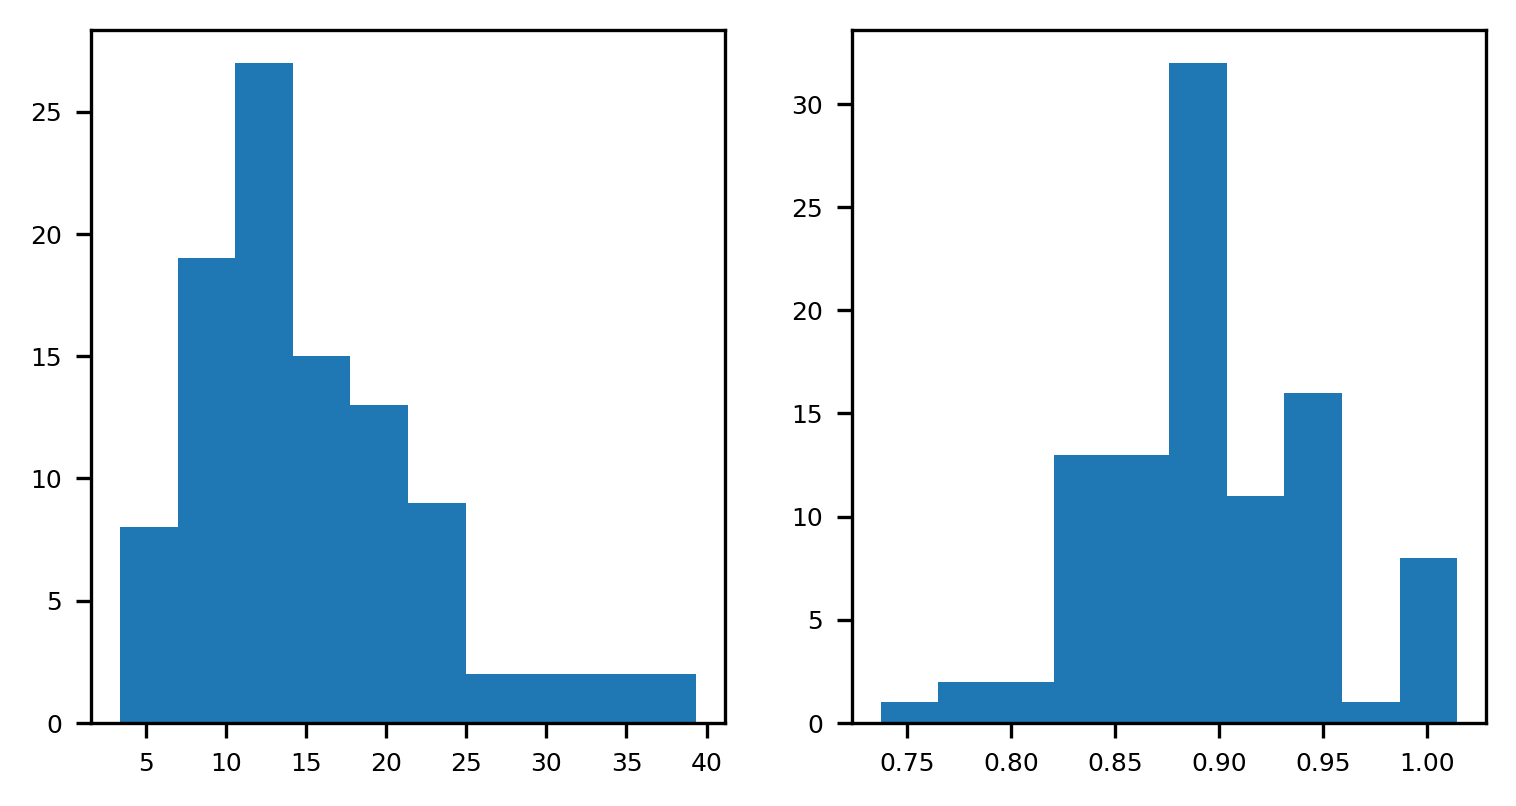

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
plt.sca(axs[0])
plt.hist(site_data.turnover)
plt.sca(axs[1])
plt.hist(site_data.fm)

In [1]:
from soil_diskin.data_wrangling import process_balesdent_data
import pandas as pd

raw_data = pd.read_excel('../data/balesdent_2018/balesdent_2018_raw.xlsx', sheet_name='Profiles', skiprows=7)
all_sites = process_balesdent_data(raw_data)
all_sites.shape

(99, 14)

In [2]:
mask = all_sites['Ctotal_0-100estim'].isna()
all_sites[mask]

,Latitude,Longitude,Duration_labeling,total_fnew,weight_10,weight_20,weight_30,weight_40,weight_50,weight_60,weight_70,weight_80,weight_90,Ctotal_0-100estim
0,-28.666667,153.333333,35.0,0.142256,0.208974,0.170171,0.128806,0.113073,0.088658,0.081349,0.075345,0.067736,0.065889,NaN
1,-28.666667,153.333333,83.0,0.367060,0.208974,0.170171,0.128806,0.113073,0.088658,0.081349,0.075345,0.067736,0.065889,NaN
19,-7.516667,-63.033333,4000.0,0.914807,0.208974,0.170171,0.128806,0.113073,0.088658,0.081349,0.075345,0.067736,0.065889,NaN
27,-4.066667,12.216667,1000.0,0.764441,0.208974,0.170171,0.128806,0.113073,0.088658,0.081349,0.075345,0.067736,0.065889,NaN
28,-4.033333,15.383333,1000.0,0.953537,0.208974,0.170171,0.128806,0.113073,0.088658,0.081349,0.075345,0.067736,0.065889,NaN
29,-3.800000,15.366667,1000.0,0.847718,0.208974,0.170171,0.128806,0.113073,0.088658,0.081349,0.075345,0.067736,0.065889,NaN
30,-3.633333,13.183333,1000.0,0.853956,0.208974,0.170171,0.128806,0.113073,0.088658,0.081349,0.075345,0.067736,0.065889,NaN
31,-3.200000,12.350000,40.0,0.073263,0.208974,0.170171,0.128806,0.113073,0.088658,0.081349,0.075345,0.067736,0.065889,NaN
32,-3.200000,12.350000,1000.0,0.633866,0.208974,0.170171,0.128806,0.113073,0.088658,0.081349,0.075345,0.067736,0.065889,NaN
38,2.566667,-60.366667,4000.0,0.899293,0.208974,0.170171,0.128806,0.113073,0.088658,0.081349,0.075345,0.067736,0.065889,NaN


In [8]:

colnames = raw_data.columns
cols2show = colnames.str.startswith('Ctotal')
cols2show = ['Ctotal_0-{}'.format(i) for i in range(10, 110, 10)]
cols2show += ['Ctotal_0-100estim', 'Latitude', 'Longitude']

mask = raw_data['Ctotal_0-100estim'].isna()
raw_data[mask][cols2show]

,Ctotal_0-10,Ctotal_0-20,Ctotal_0-30,Ctotal_0-40,Ctotal_0-50,Ctotal_0-60,Ctotal_0-70,Ctotal_0-80,Ctotal_0-90,Ctotal_0-100,Ctotal_0-100estim,Latitude,Longitude
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-28.666667,153.333333
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-28.666667,153.333333
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.200000,12.350000
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.343833,-52.933667
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.200000,12.350000
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.033333,15.383333
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.800000,15.366667
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.066667,12.216667
108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.633333,13.183333
110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.566667,-60.366667
